In [1]:
import pandas as pd
import numpy as np
import sqlite3
import os.path
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import pickle as pk
import qgrid

pd.set_option("display.max_rows",15)
%matplotlib inline

In [2]:
conn = create_engine('sqlite:///../dataset/ijcai_cff_2017.db')

In [3]:
no_of_shops = 2000
shops = pd.DataFrame({"shop_id":np.arange(start=1, stop = (no_of_shops+1))})
shops.to_sql("shops", index = False, con = conn, if_exists='replace')

In [4]:
train_data = []
train_data_raw = pd.read_sql_query("select d.shop_id, "
                                   "d.total_view + d.total_pay as input_foot_traffic "
                                   "from train_data d "
                                   #"where shop_id = {}".format(i) 
                                   ,con = conn)


In [5]:
shape_of_network = [7,1]

In [6]:
train_data = train_data_raw.dropna(how = "any")
train_data = train_data.set_index("shop_id")
qgrid.show_grid(train_data.loc[1:10])
train_data.loc[1:10]

Widget Javascript not detected.  It may not be installed or enabled properly.


,input_foot_traffic
shop_id,
1,178.0
1,233.0
1,250.0
1,234.0
1,230.0
1,237.0
1,191.0
...,...
10,61.0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

impute_x = Imputer()
impute_y = Imputer()

scaler = StandardScaler()

def scale(x):
    return scaler.fit_transform(x)

def reverse_scale(x):
    return scaler.inverse_transform(x)

def split(x,y_):
    x_train, x_valid, y_train, y_valid = train_test_split(
    x, y_ , test_size=0.45, random_state=42)
    
    x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid, y_valid , test_size=0.15, random_state=42)
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test 

In [8]:
train = train_data.loc[1] # Select which shop
shape = train.values.shape
train_scaled = scale(train.values.ravel().reshape(-1, 1)).reshape(shape)
train_scaled.shape

(130, 1)

In [9]:
skip = train_scaled.shape[0] % (shape_of_network[0] + shape_of_network[1])
if skip is not 0:
    train_trim = train_scaled[skip:,]
train_trim.shape

(128, 1)

In [10]:
step = shape_of_network[0]
x_arr = []
y_arr = []
for i in range(0, train_trim.shape[0]-skip, step):
    x_arr.append(train_trim[i:i+shape_of_network[0]].flatten())
    y_arr.append(train_trim[i+shape_of_network[0]].flatten())

x_arr = np.array(x_arr)
y_arr = np.array(y_arr)

print("x: {}".format(x_arr))
print("y: {}".format(y_arr))

x: [[ -5.92125426e-01  -8.89259536e-01  -9.63543063e-01  -8.33546890e-01
   -1.68780746e+00  -5.17841898e-01  -3.87845725e-01]
 [ -2.57849552e-01  -1.18639365e+00  -1.07496835e+00  -4.06416607e-01
   -2.76420434e-01  -7.22121599e-01  -1.83566025e-01]
 [  7.07836305e-01  -3.69274843e-01  -1.27853379e-01   2.80706022e-01
   -7.22121599e-01  -1.14925188e+00  -8.33546890e-01]
 [ -3.13562198e-01   1.13568085e-01  -9.07830418e-01  -4.24987489e-01
   -2.94991316e-01  -6.29267190e-01  -3.69274843e-01]
 [ -2.20707788e-01  -4.80700135e-01  -1.05639747e+00  -1.64280878e-02
   -8.52117772e-01   1.50709849e-01  -3.49989697e-02]
 [ -1.05639747e+00  -3.32133080e-01  -9.07830418e-01   2.63920802e+00
    2.54635361e+00   4.77485944e+00  -2.76420434e-01]
 [  2.14279406e-03   3.73560432e-01   1.13496659e+00  -3.13562198e-01
    3.92845578e-02  -1.64995143e-01   2.24993377e-01]
 [  5.78554397e-02  -4.62129253e-01  -1.83566025e-01  -2.76420434e-01
    5.22127487e-01  -3.87845725e-01  -5.36412780e-01]
 [ -2

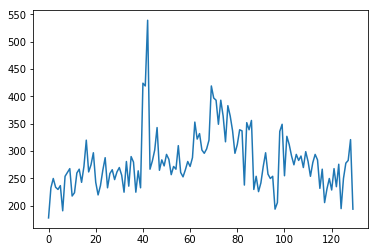

In [11]:
plt.plot(train.values.ravel())

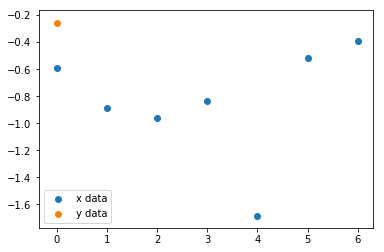

In [12]:
plt.scatter([range(x_arr[0].ravel().shape[0])],x_arr[0].ravel(), label = "x data")
plt.scatter([range(y_arr[0].ravel().shape[0])], y_arr[0].ravel(), label = "y data")
plt.legend()

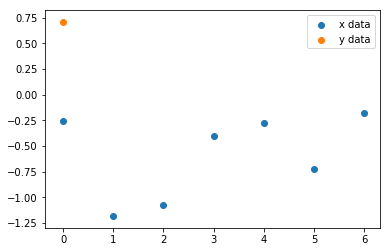

In [13]:
plt.scatter([range(x_arr[1].ravel().shape[0])],x_arr[1].ravel(), label = "x data")
plt.scatter([range(y_arr[1].ravel().shape[0])], y_arr[1].ravel(), label = "y data")
plt.legend()

In [14]:
print("x shape {}".format(x_arr.shape))
print("y shape {}".format(y_arr.shape))
x_train, x_valid, x_test, y_train, y_valid, y_test = split(x_arr, y_arr)

x shape (18, 7)
y shape (18, 1)


In [45]:
import tensorflow as tf

session = tf.InteractiveSession()

with tf.name_scope("inputs"):
    x = tf.placeholder(dtype = tf.float64, shape = [None, shape_of_network[0]])
    y_ = tf.placeholder(dtype = tf.float64, shape = [None, shape_of_network[1]])

with tf.name_scope("weights"):
    w_h = tf.Variable(tf.truncated_normal(shape = [shape_of_network[0], shape_of_network[0]], dtype = tf.float64))
    w_o = tf.Variable(tf.truncated_normal(shape = [shape_of_network[0], shape_of_network[1]], dtype = tf.float64))

with tf.name_scope("biases"):
    b_h = tf.Variable(tf.constant(value = 0.1, dtype = tf.float64, shape=[shape_of_network[0]]))
    b_o = tf.Variable(tf.constant(value = 0.1, dtype = tf.float64, shape=[shape_of_network[1]]))

with tf.name_scope("dense_layer"):
    y_h = tf.nn.relu(tf.matmul(x , w_h) + b_h)
    tf.summary.histogram(name="hidden_weights", values = w_h)

with tf.name_scope("prediction"):
    y = tf.matmul(y_h, w_o) + b_o
    tf.summary.histogram(name="output_weights", values = w_o)

with tf.name_scope("cost"):
    loss_comp = tf.reduce_mean(
        tf.abs(
            tf.divide(
                tf.subtract(y, y_),
                tf.add(y, y_)
            )
        )
    )
    tf.summary.scalar(name="cost_comp",  tensor = loss_comp)
    
    loss = tf.reduce_mean(tf.squared_difference(y, y_))
    tf.summary.scalar(name="cost_mse",  tensor = loss)
    
with tf.name_scope("optimizer"):
    gradient = tf.train.AdamOptimizer(0.01).minimize(loss_comp)

In [46]:
session.run(tf.global_variables_initializer())
merged = tf.summary.merge_all()
file_writer = tf.summary.FileWriter("./logs/7", session.graph)

In [47]:
train_loss_arr =  []
valid_loss_arr = []
comp_valid_loss_arr = []

for i in range(5000):
    _, train_loss, summary = session.run([gradient, loss, merged], feed_dict = {x:x_train, y_:y_train})
    valid_loss = loss.eval(feed_dict = {x:x_valid, y_:y_valid})
    comp_valid_loss = loss_comp.eval(feed_dict = {x:x_valid, y_:y_valid})
    
    train_loss_arr.append(train_loss)
    valid_loss_arr.append(valid_loss)
    comp_valid_loss_arr.append(comp_valid_loss)
    
    if(i % 500 == 0):
        print("epoch: {} training {} validation {} Competition {}".format(i, train_loss, valid_loss, comp_valid_loss))
        file_writer.add_summary(summary, i)

InvalidArgumentError: You must feed a value for placeholder tensor 'keras_dense_1/dense_3_input' with dtype float
	 [[Node: keras_dense_1/dense_3_input = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'keras_dense_1/dense_3_input', defined at:
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-786c52a7d60c>", line 10, in <module>
    model.add(Dense(shape_of_network[0], input_dim = shape_of_network[0], kernel_initializer='uniform' ,activation = 'relu'))
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/keras/models.py", line 418, in add
    dtype=layer.dtype, name=layer.name + '_input')
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/keras/engine/topology.py", line 1388, in Input
    input_tensor=tensor)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/keras/engine/topology.py", line 1299, in __init__
    name=self.name)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 349, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'keras_dense_1/dense_3_input' with dtype float
	 [[Node: keras_dense_1/dense_3_input = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


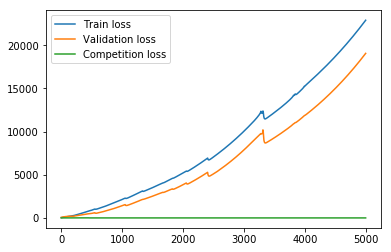

In [18]:
plt.plot(train_loss_arr, label="Train loss")
plt.plot(valid_loss_arr, label="Validation loss")
plt.plot(comp_valid_loss_arr, label="Competition loss")

plt.legend()

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks

model = Sequential()
with tf.name_scope("keras_dense"):
    model.add(Dense(shape_of_network[0], input_dim = shape_of_network[0], kernel_initializer='uniform' ,activation = 'relu'))
    #model.add(Dense(shape_of_network[0], kernel_initializer='uniform' ,activation = 'relu'))
    model.add(Dense(shape_of_network[1], kernel_initializer='uniform', activation=None))
#with tf.name_scope("keras_loss"):
def k_loss(k_y_, k_y):
    return tf.reduce_mean(
        tf.abs(
            tf.divide(
                tf.subtract(k_y, k_y_),
                tf.add(k_y, k_y_)
            )
        )
    )
model.compile(loss = k_loss, optimizer="adam")


In [39]:
#tensorboard_callback = callbacks.TensorBoard(log_dir='./logs/5', histogram_freq=0, write_graph=True, write_images=True)
with tf.name_scope("keras_fit"):
    model.fit(x_train, y_train, epochs = 10, validation_data = (x_valid, y_valid))

Train on 9 samples, validate on 7 samples
Epoch 1/10
9/9 [==============================] - 0s - loss: 1.0114 - val_loss: 0.9713
Epoch 2/10
9/9 [==============================] - 0s - loss: 1.0042 - val_loss: 0.9772
Epoch 3/10
9/9 [==============================] - 0s - loss: 0.9975 - val_loss: 0.9825
Epoch 4/10
9/9 [==============================] - 0s - loss: 0.9912 - val_loss: 0.9878
Epoch 5/10
9/9 [==============================] - 0s - loss: 0.9850 - val_loss: 0.9927
Epoch 6/10
9/9 [==============================] - 0s - loss: 0.9791 - val_loss: 0.9972
Epoch 7/10
9/9 [==============================] - 0s - loss: 0.9735 - val_loss: 1.0014
Epoch 8/10
9/9 [==============================] - 0s - loss: 0.9680 - val_loss: 1.0056
Epoch 9/10
9/9 [==============================] - 0s - loss: 0.9629 - val_loss: 1.0098
Epoch 10/10
9/9 [==============================] - 0s - loss: 0.9582 - val_loss: 1.0138


In [37]:
scores = model.evaluate(x_test, y_test)
scores

2/2 [==============================] - 0s


0.7889254093170166

In [22]:
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(shape_of_network[0], input_shape=(None, None, 7)))
model.compile(loss = losses.mean_squared_error, optimizer="adam")

ValueError: Input 0 is incompatible with layer lstm_1: expected ndim=3, found ndim=4

In [ ]:
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_valid_reshaped = np.reshape(x_valid, (x_valid.shape[0], 1, x_valid.shape[1]))
print(x_train_reshaped.shape)

In [ ]:
model.fit(x_train_reshaped, y_train, epochs = 10, validation_data = (x_valid, y_valid))

In [ ]:
#scores = model.evaluate(x_test, y_test)
#scores